## Imports

In [176]:
import pandas as pd
import glob
import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Read Data

In [177]:
wiki_data = pd.read_csv(
    "../../data/wikidata/wikipedia-articles-per-lang-june-2022.tsv", sep="\t"
)

In [178]:
wiki_data = wiki_data.rename(columns={"lang": "language"})

In [179]:
wiki_data.head()

,code,language,June_2022_article_count,June_2022_date,Url
0,bg:,Bulgarian,"282,130",6/14/2022,https://web.archive.org/web/20220614194239/htt...
1,ca:,Catalan,"702,281",6/14/2022,https://web.archive.org/web/20220614194621/htt...
2,cs:,Czech,"505,105",6/14/2022,https://web.archive.org/web/20220614015357/htt...
3,da:,Danish,"280,923",6/14/2022,https://web.archive.org/web/20220614020329/htt...
4,de:,German,"2,698,267",6/15/2022,https://web.archive.org/web/20220615000601/htt...


In [180]:
entity_analysis_df = pd.read_csv(
    "../../data/error_analysis/entity_analysis_language_and_accuracy_by_entity.csv"
)

In [181]:
entity_analysis_df.head()

,entity,num_correct,num_incorrect,total_usages,percent_accuracy,languages,num_languages,alternate_forms,dataset_ids
0,Prius,16,0,16,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",16,"{'sr': 'Приус', 'uk': 'Prius', 'nl': 'Prius', ...",['calinet_8922']
1,Sundar Pichai,18,1,19,0.947368,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'ca': 1, ...",19,"{'sr': 'Сундар Пицхаи', 'uk': 'Сундар Пічаї', ...",['rome_5025']
2,People's Republic of China,17,0,17,1.000000,"{'sr': 1, 'uk': 1, 'nl': 1, 'sv': 1, 'hu': 1, ...",17,"{'sr': 'Народна Република Кина', 'uk': 'Народн...",['rome_21333']
3,Sint Maarten,11,10,21,0.523810,"{'sr': 1, 'nl': 2, 'sv': 1, 'ca': 1, 'pl': 1, ...",14,"{'sr': 'Синт Маартен', 'nl': 'Sint Maarten', '...","['rome_8738', 'rome_20596']"
4,Haas House,9,5,14,0.642857,"{'sr': 1, 'nl': 1, 'sv': 1, 'hu': 1, 'ca': 1, ...",14,"{'sr': 'Хаас Хоусе', 'nl': 'Haas House', 'sv':...",['rome_8783']


In [182]:
llama_summary_df = pd.read_csv(
    "../../data/result_logs/llama-30b/results//llama-fact-completion-benchmark-results.csv"
)

In [183]:
llama_summary_df.head()

,language,accuracy,uncertainty,num_pairs
0,English,89.40,0.38,26254
1,German,85.74,0.53,16287
2,Dutch,85.35,0.46,25590
3,Italian,84.39,0.49,20448
4,French,84.18,0.52,18395


## clean data

In [184]:
agg_df = pd.merge(wiki_data, llama_summary_df, on="language", how="inner")[
    [
        "code",
        "language",
        "June_2022_article_count",
        "accuracy",
        "uncertainty",
        "num_pairs",
    ]
]

In [185]:
agg_df.head()

,code,language,June_2022_article_count,accuracy,uncertainty,num_pairs
0,bg:,Bulgarian,"282,130",72.50,0.61,20577
1,ca:,Catalan,"702,281",84.01,0.52,18898
2,cs:,Czech,"505,105",77.94,0.84,9427
3,da:,Danish,"280,923",81.79,0.50,23365
4,de:,German,"2,698,267",85.74,0.53,16287


In [186]:
int("282,130".replace(",", ""))

282130

In [187]:
agg_df["June_2022_article_count"] = [
    int(c.replace(",", "")) for c in list(agg_df["June_2022_article_count"])
]

In [188]:
agg_df["accuracy"] = [float(c) for c in list(agg_df["accuracy"])]

## is there a connection bt wikipedia size and accuracy?

first let's just graph the size of wikipedia per language

In [189]:
stats = agg_df[["language", "June_2022_article_count"]].sort_values(
    by="June_2022_article_count", ascending=True
)

### Size of wikipedia per language

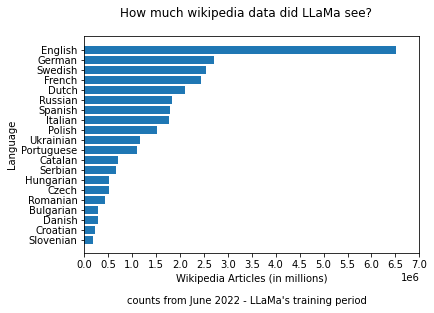

In [191]:
plt.barh("language", "June_2022_article_count", data=stats)

plt.suptitle("How much wikipedia data did LLaMa see?")
plt.xlabel("Wikipedia Articles (in millions)")
plt.ylabel("Language")
plt.xticks(range(0, max(stats["June_2022_article_count"]) + 500000, 500000))

# label the bars with the number of articles
# for i, v in enumerate(stats['June_2022_article_count']):
#    plt.text(v + 1000, i, str(v), color='blue', fontweight='bold')

txt = "counts from June 2022 - LLaMa's training period"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=10)

# display the plot
plt.show()

## accuracy and wikipedia size

In [192]:
stats = agg_df[["language", "accuracy", "code", "June_2022_article_count"]]

In [193]:
stats["code"] = [c[:-1] for c in stats["code"]]

/var/folders/02/16ydl6kx7wnfv5434ztsylf40000gn/T/ipykernel_6297/319015839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats['code'] = [c[:-1] for c in stats['code']]


In [194]:
no_english_stats = stats.drop([5]).reset_index()

In [195]:
no_english_stats.shape

(19, 5)

#### connection between accuracy and wikipedia size, including English wikipedia

We see a positive correlation between how well LLaMa did on CKA and the size of wikipedia.

In [196]:
stats["accuracy"].corr(stats["June_2022_article_count"])

0.5101122613323459

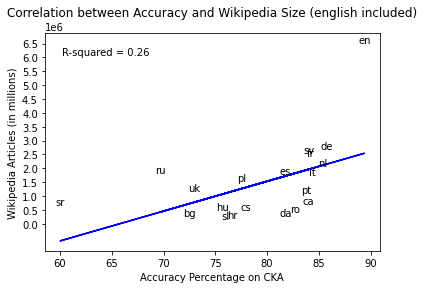

In [201]:
# create the graph

plt.title("Correlation between Accuracy and Wikipedia Size (english included)")
plt.scatter(
    stats["accuracy"],
    stats["June_2022_article_count"],
    facecolors="none",
    edgecolors="none",
)

plt.xlabel("Accuracy Percentage on CKA")
plt.ylabel("Wikipedia Articles (in millions)")

plt.yticks(range(0, max(stats["June_2022_article_count"]) + 500000, 500000))

# add trendline
slope, intercept, r_value, p_value, std_err = linregress(
    stats["accuracy"], stats["June_2022_article_count"]
)
plt.plot(stats["accuracy"], intercept + slope * stats["accuracy"], "b")

# add legend with r-squared value
r_squared = r_value**2
plt.annotate(
    "R-squared = {:.2f}".format(r_squared), xy=(0.05, 0.9), xycoords="axes fraction"
)

for i, txt in enumerate(stats["code"]):
    plt.annotate(
        txt, (stats["accuracy"][i], stats["June_2022_article_count"][i]), ha="center"
    )

plt.show()

#### connection between accuracy and wikipedia size, without English wikipedia

when you remove english from the group, the positive correlation drops

In [203]:
no_english_stats["accuracy"].corr(no_english_stats["June_2022_article_count"])

0.42304002440971117

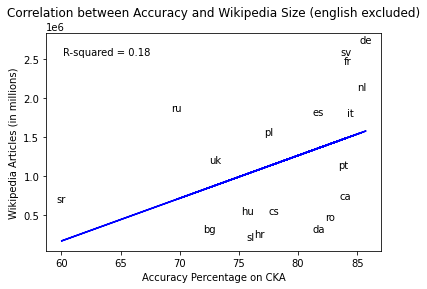

In [205]:
# create the graph

# remove english

plt.title("Correlation between Accuracy and Wikipedia Size (english excluded)")
plt.scatter(
    no_english_stats["accuracy"],
    no_english_stats["June_2022_article_count"],
    facecolors="none",
    edgecolors="none",
)

plt.xlabel("Accuracy Percentage on CKA")
plt.ylabel("Wikipedia Articles (in millions)")

plt.yticks(range(0, max(stats["June_2022_article_count"]) + 500000, 500000))

# add trendline
slope, intercept, r_value, p_value, std_err = linregress(
    no_english_stats["accuracy"], no_english_stats["June_2022_article_count"]
)
plt.plot(
    no_english_stats["accuracy"], intercept + slope * no_english_stats["accuracy"], "b"
)

# add legend with r-squared value
r_squared = r_value**2
plt.annotate(
    "R-squared = {:.2f}".format(r_squared), xy=(0.05, 0.9), xycoords="axes fraction"
)

for i, txt in enumerate(no_english_stats["code"]):
    plt.annotate(
        txt,
        (
            no_english_stats["accuracy"][i],
            no_english_stats["June_2022_article_count"][i],
        ),
        ha="center",
    )

plt.show()

In [204]:
# stats['regression_outcome'] = np.where(stats["June_2022_article_count"] > intercept + slope * stats["accuracy"], "worse than expectation", "better than expectation")